In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import cv2
from tqdm import tqdm
import json
import shutil
from datetime import datetime

In [2]:
# Enhanced Binary Crime Detector with better architecture
class EnhancedBinaryCrimeDetector(nn.Module):
    """
    Enhanced binary crime detector using ResNet50 backbone with attention mechanism
    """
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()
        
        # Use pre-trained ResNet50 as backbone
        base = models.resnet50(weights="IMAGENET1K_V2")
        self.feature_extractor = nn.Sequential(*list(base.children())[:-2])  # Remove avgpool and fc
        
        # Temporal modeling with 3D convolutions
        self.temporal_conv = nn.Sequential(
            nn.Conv3d(2048, 512, kernel_size=(3, 1, 1), padding=(1, 0, 0)),
            nn.BatchNorm3d(512),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout),
            
            nn.Conv3d(512, 256, kernel_size=(3, 1, 1), padding=(1, 0, 0)),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((None, 1, 1))  # Keep temporal dimension
        )
        
        # Enhanced attention mechanism
        self.attention = nn.Sequential(
            nn.Conv3d(256, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Enhanced classifier with better regularization
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x, return_attention=False):
        """
        Args:
            x: input tensor (B, C, T, H, W)
            return_attention: if True, return attention weights along with predictions
        """
        batch_size, channels, timesteps, height, width = x.shape
        
        # Process each frame through ResNet backbone
        frame_features = []
        for t in range(timesteps):
            frame = x[:, :, t, :, :]  # (B, C, H, W)
            features = self.feature_extractor(frame)  # (B, 2048, H', W')
            frame_features.append(features.unsqueeze(2))  # Add temporal dimension
        
        # Stack along temporal dimension: (B, 2048, T, H', W')
        spatial_features = torch.cat(frame_features, dim=2)
        
        # Temporal modeling
        temporal_features = self.temporal_conv(spatial_features)  # (B, 256, T, 1, 1)
        
        # Compute attention weights
        attention_weights = self.attention(temporal_features)  # (B, 1, T, 1, 1)
        attention_weights = attention_weights.squeeze()  # (B, T)
        
        # Apply attention
        if len(attention_weights.shape) == 1:  # Handle batch size 1
            attention_weights = attention_weights.unsqueeze(0)
        weighted_features = temporal_features * attention_weights.unsqueeze(1).unsqueeze(3).unsqueeze(4)
        
        # Classification
        logits = self.classifier(weighted_features)
        
        if return_attention:
            return logits, attention_weights
        return logits

In [3]:
# Enhanced dataset with better data loading and augmentation
class EnhancedUCFCrimeBinaryDataset(Dataset):
    """
    Enhanced dataset with better frame sampling and data augmentation
    """
    def __init__(self, root_dir, clip_len=16, frame_size=224, is_training=True):
        self.root_dir = root_dir
        self.clip_len = clip_len
        self.frame_size = frame_size
        self.is_training = is_training
        
        # Different transforms for training and validation
        if is_training:
            self.transform = transforms.Compose([
                transforms.Resize((frame_size, frame_size)),
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((frame_size, frame_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
        self.samples = []
        self.video_metadata = []
        self._prepare_samples()
        
    def _prepare_samples(self):
        """Scan directory for MP4 video files with enhanced filtering"""
        crime_categories = [
            "Abuse", "Arrest", "Arson", "Assault", "Burglary", 
            "Explosion", "Fighting", "RoadAccidents", "Robbery", 
            "Shooting", "Shoplifting", "Stealing", "Vandalism"
        ]
        
        for category in os.listdir(self.root_dir):
            category_path = os.path.join(self.root_dir, category)
            if not os.path.isdir(category_path):
                continue

            # Determine label and crime type
            if category.lower() == "normalvideos":
                label = 0
                crime_type = "Normal"
            else:
                label = 1
                # Extract crime type from folder name
                crime_type = "Unknown"
                for crime_cat in crime_categories:
                    if crime_cat.lower() in category.lower():
                        crime_type = crime_cat
                        break

            for file in os.listdir(category_path):
                if file.lower().endswith('.mp4'):
                    video_path = os.path.join(category_path, file)
                    
                    # Store sample
                    self.samples.append((video_path, label))
                    
                    # Store metadata
                    self.video_metadata.append({
                        'video_path': video_path,
                        'true_label': label,
                        'crime_type': crime_type,
                        'category': category,
                        'filename': file
                    })
        
        print(f"Found {len(self.samples)} videos in {self.root_dir}")
        
    def _load_video_cv2(self, video_path):
        """Enhanced video loading with better frame sampling"""
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video: {video_path}")

        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        if total_frames == 0:
            cap.release()
            raise ValueError(f"No frames in video: {video_path}")
        
        # Enhanced frame sampling strategy
        if self.is_training and total_frames > self.clip_len:
            # Random sampling for training
            start_frame = np.random.randint(0, max(1, total_frames - self.clip_len))
            frame_indices = range(start_frame, min(start_frame + self.clip_len, total_frames))
        else:
            # Uniform sampling for validation
            frame_indices = np.linspace(0, total_frames - 1, self.clip_len, dtype=int)

        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                # If frame reading fails, try to read the last successful frame
                if frames:
                    frame = frames[-1].copy()
                else:
                    # If no frames read yet, create a black frame
                    frame = np.zeros((self.frame_size, self.frame_size, 3), dtype=np.uint8)
                    ret = True
            
            if ret:
                # Convert BGR to RGB and resize
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (self.frame_size, self.frame_size))
                frames.append(frame)

        cap.release()

        # Pad if needed
        while len(frames) < self.clip_len:
            if frames:
                frames.append(frames[-1])
            else:
                frames.append(np.zeros((self.frame_size, self.frame_size, 3), dtype=np.uint8))

        return frames[:self.clip_len]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        
        try:
            frames = self._load_video_cv2(video_path)
            imgs = []
            
            for frame in frames:
                frame_pil = Image.fromarray(frame)
                frame_tensor = self.transform(frame_pil)
                imgs.append(frame_tensor)
            
            # Stack as (C, T, H, W)
            clip_tensor = torch.stack(imgs, dim=1)
            return clip_tensor, torch.tensor(label, dtype=torch.long), video_path
            
        except Exception as e:
            print(f"[LOAD FAILED] {video_path} | Error: {e}")
            # Return meaningful dummy tensor
            dummy = torch.zeros(3, self.clip_len, self.frame_size, self.frame_size)
            return dummy, torch.tensor(label, dtype=torch.long), video_path

In [4]:
# Enhanced evaluation with JSON output
def evaluate_with_json_output(model, data_loader, device, output_dir):
    """
    Evaluate model and save detailed results to JSON
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_confidences = []
    video_results = []
    
    with torch.no_grad():
        for clips, labels, video_paths in tqdm(data_loader, desc="Evaluating"):
            clips, labels = clips.to(device), labels.to(device)
            
            # Get predictions and attention weights
            logits, attention_weights = model(clips, return_attention=True)
            probabilities = torch.softmax(logits, dim=1)
            confidences, predictions = torch.max(probabilities, dim=1)
            
            for i in range(len(clips)):
                # Store results for this video
                video_result = {
                    'video_path': video_paths[i],
                    'true_label': int(labels[i].item()),
                    'predicted_label': int(predictions[i].item()),
                    'confidence': float(confidences[i].item()),
                    'crime_probability': float(probabilities[i, 1].item()),  # Probability it's crime
                    'normal_probability': float(probabilities[i, 0].item()),  # Probability it's normal
                    'attention_weights': attention_weights[i].cpu().tolist() if len(attention_weights.shape) > 1 else attention_weights.cpu().tolist(),
                    'correct': bool(predictions[i].item() == labels[i].item()),
                    'timestamp': datetime.now().isoformat()
                }
                video_results.append(video_result)
                
                # Store for metrics calculation
                all_predictions.append(predictions[i].item())
                all_labels.append(labels[i].item())
                all_confidences.append(confidences[i].item())
    
    # Calculate overall metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary')
    recall = recall_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')
    
    # Create comprehensive results dictionary
    results_dict = {
        'evaluation_metadata': {
            'timestamp': datetime.now().isoformat(),
            'total_videos': len(video_results),
            'normal_videos': sum(1 for r in video_results if r['true_label'] == 0),
            'crime_videos': sum(1 for r in video_results if r['true_label'] == 1),
            'overall_accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1_score': float(f1)
        },
        'video_predictions': video_results,
        'anomalies_detected': [
            result for result in video_results 
            if result['predicted_label'] == 1 and result['crime_probability'] > 0.5
        ]
    }
    
    # Save results to JSON
    json_path = os.path.join(output_dir, "anomaly_detection_results.json")
    with open(json_path, 'w') as f:
        json.dump(results_dict, f, indent=2)
    
    print(f"Saved detailed results to {json_path}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Anomalies detected: {len(results_dict['anomalies_detected'])}")
    
    return results_dict

In [5]:
# Enhanced high-attention frame extraction with crime type information
def extract_high_attention_frames_for_multiclass(model, data_loader, device, output_dir, top_k=3, confidence_threshold=0.7):
    """
    Extract high-attention frames from crime videos for Stage 2 multi-class training
    """
    model.eval()
    high_attention_data = []
    crime_categories = []
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Create frame output directory
    frames_output_dir = os.path.join(output_dir, "high_attention_frames")
    os.makedirs(frames_output_dir, exist_ok=True)
    
    with torch.no_grad():
        for clips, labels, video_paths in tqdm(data_loader, desc="Extracting high-attention frames"):
            clips, labels = clips.to(device), labels.to(device)
            
            # Get predictions and attention weights
            logits, attention_weights = model(clips, return_attention=True)
            predictions = torch.softmax(logits, dim=1)
            
            for i in range(len(clips)):
                # Only save frames from videos classified as crime with high confidence
                if labels[i] == 1 and predictions[i, 1] > confidence_threshold:
                    clip = clips[i]
                    attn_weights = attention_weights[i]
                    
                    # Get crime type from video path
                    crime_type = "Unknown"
                    video_path = video_paths[i]
                    crime_categories = ["Abuse", "Arrest", "Arson", "Assault", "Burglary", 
                                      "Explosion", "Fighting", "RoadAccidents", "Robbery", 
                                      "Shooting", "Shoplifting", "Stealing", "Vandalism"]
                    
                    for crime_cat in crime_categories:
                        if crime_cat.lower() in video_path.lower():
                            crime_type = crime_cat
                            break
                    
                    # Get top-k frames with highest attention
                    top_indices = torch.topk(attn_weights, min(top_k, len(attn_weights))).indices
                    
                    for frame_idx in top_indices:
                        frame_tensor = clip[:, frame_idx, :, :].cpu()
                        
                        # Save frame as image for inspection
                        frame_id = f"{os.path.basename(video_path).split('.')[0]}_frame{frame_idx.item()}"
                        frame_path = os.path.join(frames_output_dir, f"{frame_id}.png")
                        
                        # Convert tensor to PIL Image and save
                        frame_np = frame_tensor.numpy().transpose(1, 2, 0)
                        frame_np = (frame_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
                        frame_np = np.clip(frame_np, 0, 255).astype(np.uint8)
                        frame_pil = Image.fromarray(frame_np)
                        frame_pil.save(frame_path)
                        
                        frame_data = {
                            'frame_tensor': frame_tensor,
                            'frame_path': frame_path,
                            'attention_weight': attn_weights[frame_idx].item(),
                            'video_path': video_path,
                            'frame_index': frame_idx.item(),
                            'crime_probability': predictions[i, 1].item(),
                            'crime_type': crime_type,
                            'crime_type_index': crime_categories.index(crime_type) if crime_type in crime_categories else -1
                        }
                        high_attention_data.append(frame_data)
    
    # Save for Stage 2 training
    torch.save(high_attention_data, os.path.join(output_dir, "multiclass_training_data.pth"))
    
    # Save metadata about extracted frames
    frame_metadata = {
        'total_frames': len(high_attention_data),
        'crime_type_distribution': {},
        'extraction_timestamp': datetime.now().isoformat(),
        'confidence_threshold': confidence_threshold
    }
    
    for data in high_attention_data:
        crime_type = data['crime_type']
        frame_metadata['crime_type_distribution'][crime_type] = frame_metadata['crime_type_distribution'].get(crime_type, 0) + 1
    
    with open(os.path.join(output_dir, "frame_metadata.json"), 'w') as f:
        json.dump(frame_metadata, f, indent=2)
    
    print(f"Saved {len(high_attention_data)} high-attention frames for Stage 2 multi-class training")
    print("Crime type distribution:", frame_metadata['crime_type_distribution'])
    
    return high_attention_data

In [6]:
# Enhanced training function with JSON output
def train_enhanced_model_with_json():
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    CLIP_LEN = 16
    FRAME_SIZE = 224
    OUTPUT_DIR = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_v2\stage1_outv3"
    
    print(f"Using device: {DEVICE}")
    print(f"Frame size: {FRAME_SIZE}")
    
    # Create datasets
    train_dir = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_v2\Train"
    test_dir = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_v2\Test"
    
    train_data = EnhancedUCFCrimeBinaryDataset(
        train_dir, clip_len=CLIP_LEN, frame_size=FRAME_SIZE, is_training=True
    )
    test_data = EnhancedUCFCrimeBinaryDataset(
        test_dir, clip_len=CLIP_LEN, frame_size=FRAME_SIZE, is_training=False
    )
    
    train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=2, shuffle=False, num_workers=0)
    
    print(f"Train clips: {len(train_data)}, Test clips: {len(test_data)}")
    
    # Initialize enhanced model
    model = EnhancedBinaryCrimeDetector(num_classes=2, dropout=0.5).to(DEVICE)
    
    # Enhanced loss function with class weighting
    class_counts = [170, 760]  # From your distribution analysis
    total_samples = sum(class_counts)
    class_weights = [total_samples / count for count in class_counts]
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    # Training metrics tracking
    train_losses = []
    val_accuracies = []
    best_accuracy = 0
    
    for epoch in range(5):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/5 [Train]')
        for clips, labels, _ in pbar:
            clips, labels = clips.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(clips)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for clips, labels, _ in test_loader:
                clips, labels = clips.to(DEVICE), labels.to(DEVICE)
                outputs = model(clips)
                _, predicted = torch.max(outputs.data, 1)
                
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100. * val_correct / val_total
        val_accuracies.append(val_accuracy)
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
        print(f"  Val Acc: {val_accuracy:.2f}%")
        
        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "enhanced_binary_crime_detector.pth"))
            print(f"  New best model saved! Validation Accuracy: {val_accuracy:.2f}%")
        
        scheduler.step()
    
    print(f"\nTraining completed! Best validation accuracy: {best_accuracy:.2f}%")
    
    # Final evaluation with JSON output
    print("\n=== Final Evaluation with JSON Output ===")
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "enhanced_binary_crime_detector.pth")))
    results_dict = evaluate_with_json_output(model, test_loader, DEVICE, OUTPUT_DIR)
    
    # Extract high-attention frames for Stage 2
    print("\n=== Extracting High-Attention Frames for Stage 2 Multi-class ===")
    high_attention_data = extract_high_attention_frames_for_multiclass(
        model, test_loader, DEVICE, OUTPUT_DIR, top_k=3, confidence_threshold=0.7
    )
    
    print("Enhanced Stage 1 completed! Ready for Stage 2 multi-class training.")
    return model, results_dict, high_attention_data

In [8]:
# Main execution
if __name__ == "__main__":
    # Train the enhanced model with JSON output
    print("=== Training Enhanced Stage 1 Model with JSON Output ===")
    trained_model, results_dict, high_attention_data = train_enhanced_model_with_json()

=== Training Enhanced Stage 1 Model with JSON Output ===
Using device: cuda
Frame size: 224
Found 560 videos in C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_v2\Train
Found 70 videos in C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_v2\Test
Train clips: 560, Test clips: 70


Epoch 1/5 [Train]: 100%|██████████| 140/140 [04:40<00:00,  2.00s/it, Loss=0.0198, Acc=92.50%]



Epoch 1 Summary:
  Train Loss: 0.5535 | Train Acc: 92.50%
  Val Acc: 92.86%
  New best model saved! Validation Accuracy: 92.86%


Epoch 2/5 [Train]: 100%|██████████| 140/140 [04:47<00:00,  2.05s/it, Loss=0.0077, Acc=92.86%]



Epoch 2 Summary:
  Train Loss: 0.5973 | Train Acc: 92.86%
  Val Acc: 92.86%


Epoch 3/5 [Train]: 100%|██████████| 140/140 [04:46<00:00,  2.04s/it, Loss=1.4005, Acc=92.86%]



Epoch 3 Summary:
  Train Loss: 0.4625 | Train Acc: 92.86%
  Val Acc: 92.86%


Epoch 4/5 [Train]: 100%|██████████| 140/140 [04:42<00:00,  2.02s/it, Loss=0.0081, Acc=92.86%]



Epoch 4 Summary:
  Train Loss: 0.3885 | Train Acc: 92.86%
  Val Acc: 92.86%


Epoch 5/5 [Train]: 100%|██████████| 140/140 [04:44<00:00,  2.03s/it, Loss=0.0010, Acc=92.86%]



Epoch 5 Summary:
  Train Loss: 0.3545 | Train Acc: 92.86%
  Val Acc: 92.86%

Training completed! Best validation accuracy: 92.86%

=== Final Evaluation with JSON Output ===


Evaluating: 100%|██████████| 35/35 [00:23<00:00,  1.46it/s]


Saved detailed results to C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_v2\stage1_outv3\anomaly_detection_results.json
Overall Accuracy: 0.9286
Precision: 0.9286, Recall: 1.0000, F1: 0.9630
Anomalies detected: 70

=== Extracting High-Attention Frames for Stage 2 Multi-class ===


Extracting high-attention frames: 100%|██████████| 35/35 [00:26<00:00,  1.31it/s]

Saved 195 high-attention frames for Stage 2 multi-class training
Crime type distribution: {'Abuse': 15, 'Arrest': 15, 'Arson': 15, 'Assault': 15, 'Burglary': 15, 'Explosion': 15, 'Fighting': 15, 'RoadAccidents': 15, 'Robbery': 15, 'Shooting': 15, 'Shoplifting': 15, 'Stealing': 15, 'Vandalism': 15}
Enhanced Stage 1 completed! Ready for Stage 2 multi-class training.


=== Starting Complete Two-Stage Pipeline ===
Loading existing Stage 1 data...
Loaded 195 high-attention frames for Stage 2

=== Training Stage 2 Multi-class Classifier ===
Stage 2 Multi-class Training - Using device: cuda
Balanced dataset: 66 frames (6 per class)
Multi-class dataset: 66 frames across 13 crime types
Multi-class dataset: 39 frames across 13 crime types
Training samples: 66
Validation samples: 39


Epoch 1/30 [Train]: 100%|██████████| 3/3 [00:09<00:00,  3.28s/it, Loss=2.5467, Acc=9.09%]



Epoch 1 Summary:
  Train Loss: 2.5606 | Train Acc: 9.09%
  Val Acc: 23.08% | Val F1: 0.0903
  New best model saved! Validation Accuracy: 23.08%


Epoch 2/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.74s/it, Loss=2.5737, Acc=9.09%]



Epoch 2 Summary:
  Train Loss: 2.5650 | Train Acc: 9.09%
  Val Acc: 23.08% | Val F1: 0.0903


Epoch 3/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.76s/it, Loss=2.5231, Acc=7.58%] 



Epoch 3 Summary:
  Train Loss: 2.5432 | Train Acc: 7.58%
  Val Acc: 20.51% | Val F1: 0.0901


Epoch 4/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.76s/it, Loss=2.5926, Acc=16.67%]



Epoch 4 Summary:
  Train Loss: 2.5614 | Train Acc: 16.67%
  Val Acc: 17.95% | Val F1: 0.0873


Epoch 5/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.78s/it, Loss=2.5976, Acc=18.18%]



Epoch 5 Summary:
  Train Loss: 2.5546 | Train Acc: 18.18%
  Val Acc: 17.95% | Val F1: 0.0828


Epoch 6/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.77s/it, Loss=2.4821, Acc=21.21%]



Epoch 6 Summary:
  Train Loss: 2.5125 | Train Acc: 21.21%
  Val Acc: 20.51% | Val F1: 0.0901


Epoch 7/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, Loss=2.4906, Acc=19.70%]



Epoch 7 Summary:
  Train Loss: 2.5081 | Train Acc: 19.70%
  Val Acc: 23.08% | Val F1: 0.0903


Epoch 8/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, Loss=2.5754, Acc=21.21%]



Epoch 8 Summary:
  Train Loss: 2.5226 | Train Acc: 21.21%
  Val Acc: 23.08% | Val F1: 0.0865


Epoch 9/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, Loss=2.6176, Acc=21.21%]



Epoch 9 Summary:
  Train Loss: 2.5270 | Train Acc: 21.21%
  Val Acc: 23.08% | Val F1: 0.0865


Epoch 10/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, Loss=2.4662, Acc=22.73%]



Epoch 10 Summary:
  Train Loss: 2.4565 | Train Acc: 22.73%
  Val Acc: 23.08% | Val F1: 0.0865


Epoch 11/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, Loss=2.4495, Acc=13.64%]



Epoch 11 Summary:
  Train Loss: 2.4413 | Train Acc: 13.64%
  Val Acc: 23.08% | Val F1: 0.0865


Epoch 12/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, Loss=2.4735, Acc=15.15%]



Epoch 12 Summary:
  Train Loss: 2.4227 | Train Acc: 15.15%
  Val Acc: 23.08% | Val F1: 0.0884


Epoch 13/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, Loss=2.3184, Acc=19.70%]



Epoch 13 Summary:
  Train Loss: 2.3551 | Train Acc: 19.70%
  Val Acc: 23.08% | Val F1: 0.0903


Epoch 14/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, Loss=2.5511, Acc=21.21%]



Epoch 14 Summary:
  Train Loss: 2.4044 | Train Acc: 21.21%
  Val Acc: 23.08% | Val F1: 0.0903


Epoch 15/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, Loss=2.6093, Acc=18.18%]



Epoch 15 Summary:
  Train Loss: 2.3793 | Train Acc: 18.18%
  Val Acc: 23.08% | Val F1: 0.0903


Epoch 16/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, Loss=2.2445, Acc=18.18%]



Epoch 16 Summary:
  Train Loss: 2.2637 | Train Acc: 18.18%
  Val Acc: 23.08% | Val F1: 0.0903


Epoch 17/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, Loss=2.3577, Acc=21.21%]



Epoch 17 Summary:
  Train Loss: 2.2707 | Train Acc: 21.21%
  Val Acc: 23.08% | Val F1: 0.0903


Epoch 18/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, Loss=2.4844, Acc=15.15%]



Epoch 18 Summary:
  Train Loss: 2.3001 | Train Acc: 15.15%
  Val Acc: 23.08% | Val F1: 0.0903


Epoch 19/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, Loss=2.2839, Acc=18.18%]



Epoch 19 Summary:
  Train Loss: 2.2618 | Train Acc: 18.18%
  Val Acc: 23.08% | Val F1: 0.0944


Epoch 20/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, Loss=2.4765, Acc=15.15%]



Epoch 20 Summary:
  Train Loss: 2.3003 | Train Acc: 15.15%
  Val Acc: 23.08% | Val F1: 0.0944


Epoch 21/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, Loss=2.4937, Acc=19.70%]



Epoch 21 Summary:
  Train Loss: 2.2686 | Train Acc: 19.70%
  Val Acc: 23.08% | Val F1: 0.1038


Epoch 22/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, Loss=2.2536, Acc=22.73%]



Epoch 22 Summary:
  Train Loss: 2.2055 | Train Acc: 22.73%
  Val Acc: 23.08% | Val F1: 0.1065


Epoch 23/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, Loss=2.4136, Acc=19.70%]



Epoch 23 Summary:
  Train Loss: 2.2393 | Train Acc: 19.70%
  Val Acc: 23.08% | Val F1: 0.1154


Epoch 24/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, Loss=2.0896, Acc=16.67%]



Epoch 24 Summary:
  Train Loss: 2.1395 | Train Acc: 16.67%
  Val Acc: 23.08% | Val F1: 0.1065


Epoch 25/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, Loss=2.5599, Acc=19.70%]



Epoch 25 Summary:
  Train Loss: 2.2760 | Train Acc: 19.70%
  Val Acc: 23.08% | Val F1: 0.1154


Epoch 26/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, Loss=2.1981, Acc=22.73%]



Epoch 26 Summary:
  Train Loss: 2.1578 | Train Acc: 22.73%
  Val Acc: 23.08% | Val F1: 0.1187


Epoch 27/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.73s/it, Loss=2.8932, Acc=24.24%]



Epoch 27 Summary:
  Train Loss: 2.3758 | Train Acc: 24.24%
  Val Acc: 23.08% | Val F1: 0.1154


Epoch 28/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, Loss=2.3983, Acc=19.70%]



Epoch 28 Summary:
  Train Loss: 2.2181 | Train Acc: 19.70%
  Val Acc: 23.08% | Val F1: 0.1222


Epoch 29/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.71s/it, Loss=2.7781, Acc=21.21%]



Epoch 29 Summary:
  Train Loss: 2.3359 | Train Acc: 21.21%
  Val Acc: 23.08% | Val F1: 0.1222


Epoch 30/30 [Train]: 100%|██████████| 3/3 [00:08<00:00,  2.72s/it, Loss=2.8134, Acc=19.70%]



Epoch 30 Summary:
  Train Loss: 2.3649 | Train Acc: 19.70%
  Val Acc: 23.08% | Val F1: 0.1222


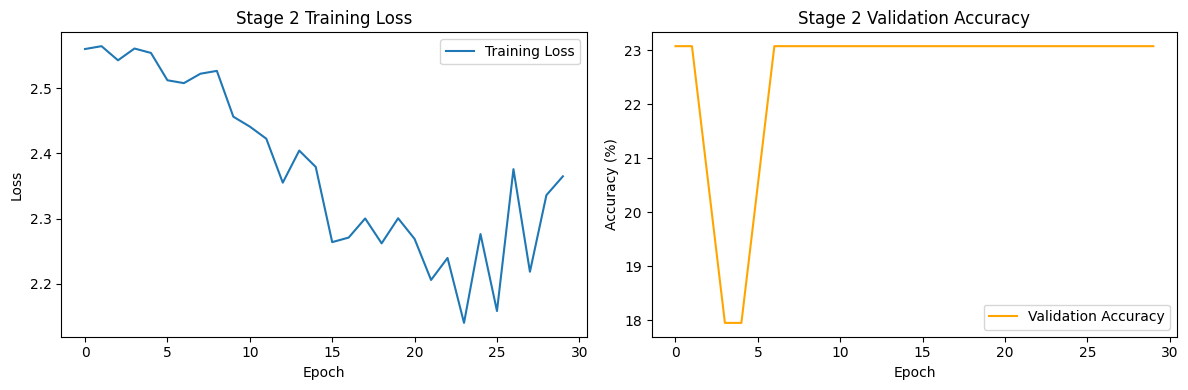


=== Evaluating Stage 2 Multi-class Classifier ===
Stage 2 Multi-class Evaluation - Using device: cuda
Multi-class dataset: 195 frames across 13 crime types


c:\Users\rayaa\anaconda3\envs\cuda_12_8\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rayaa\anaconda3\envs\cuda_12_8\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rayaa\anaconda3\envs\cuda_12_8\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

=== Stage 2 Multi-class Results ===
Overall Accuracy: 0.0769
Weighted F1-Score: 0.0112

Classification Report:
               precision    recall  f1-score   support

        Abuse       0.00      0.00      0.00        15
       Arrest       0.00      0.00      0.00        15
        Arson       0.00      0.00      0.00        15
      Assault       0.00      0.00      0.00        15
     Burglary       0.00      0.00      0.00        15
    Explosion       0.00      0.00      0.00        15
     Fighting       0.00      0.00      0.00        15
RoadAccidents       0.00      0.00      0.00        15
      Robbery       0.00      0.00      0.00        15
     Shooting       0.00      0.00      0.00        15
  Shoplifting       0.08      1.00      0.15        15
     Stealing       0.00      0.00      0.00        15
    Vandalism       0.00      0.00      0.00        15

     accuracy                           0.08       195
    macro avg       0.01      0.08      0.01       195
 weight

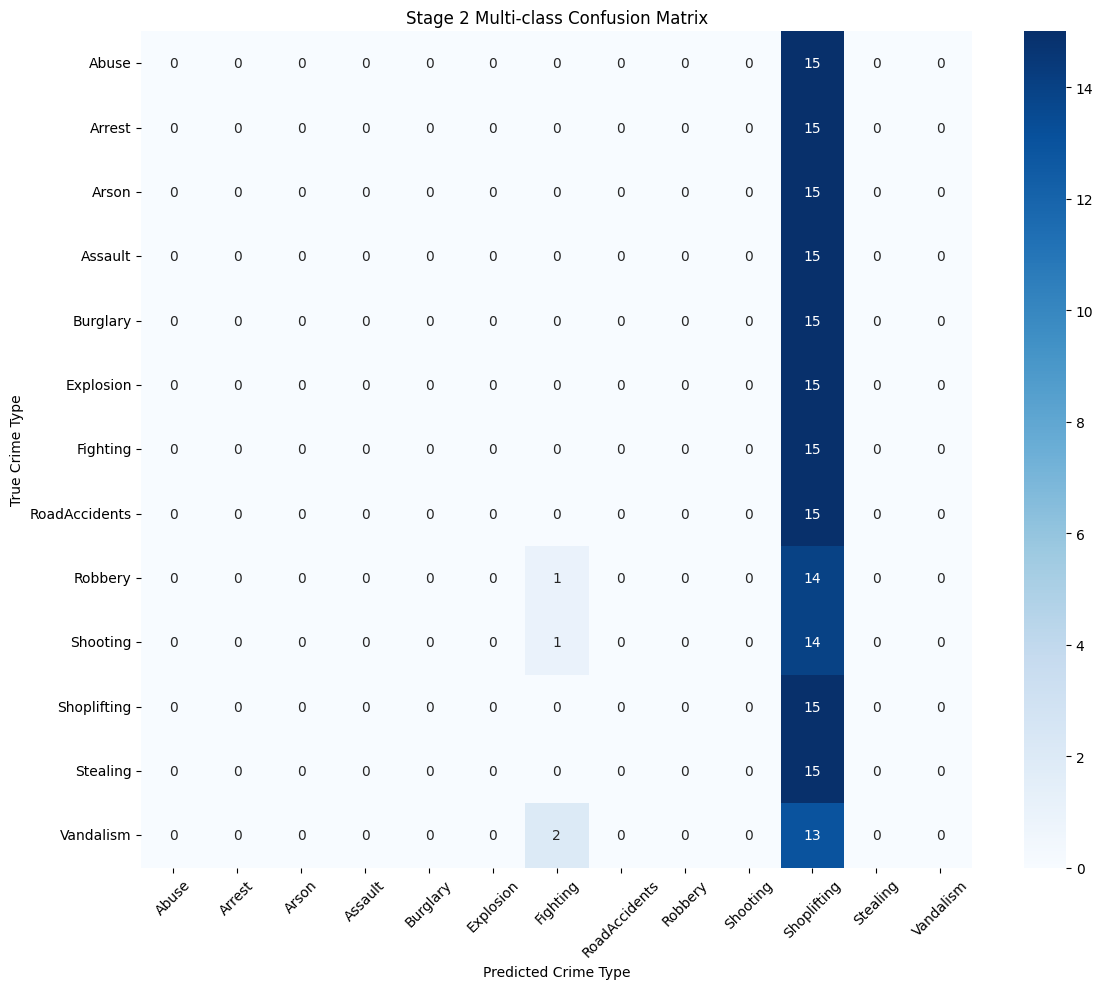


=== Pipeline Complete ===
Stage 2 Accuracy: 0.0769
Stage 2 F1-Score: 0.0112


In [10]:
# stage2_multiclass_classifier.py
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import json
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Multi-class crime type classifier for Stage 2
class MultiClassCrimeClassifier(nn.Module):
    """
    Multi-class classifier for 13 crime types using high-attention frames
    """
    def __init__(self, num_classes=13, dropout=0.3):
        super().__init__()
        
        # Use pre-trained ResNet50 as backbone
        base = models.resnet50(weights="IMAGENET1K_V2")
        self.feature_extractor = nn.Sequential(*list(base.children())[:-1])  # Remove final FC layer
        
        # Enhanced classifier for multi-class crime detection
        self.classifier = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x).squeeze()
        
        # Classification
        logits = self.classifier(features)
        return logits

# Dataset for Stage 2 multi-class training
class MultiClassCrimeDataset(Dataset):
    def __init__(self, high_attention_data, crime_categories, transform=None, balance_classes=True):
        self.high_attention_data = high_attention_data
        self.crime_categories = crime_categories
        self.transform = transform
        self.balance_classes = balance_classes
        
        # Filter out unknown crime types
        self.filtered_data = [data for data in high_attention_data if data['crime_type'] in crime_categories]
        
        if balance_classes:
            self.filtered_data = self._balance_dataset()
        
        print(f"Multi-class dataset: {len(self.filtered_data)} frames across {len(crime_categories)} crime types")
        
    def _balance_dataset(self):
        """Balance the dataset by sampling equal numbers from each crime type"""
        from collections import defaultdict
        import random
        
        # Group by crime type
        crime_groups = defaultdict(list)
        for data in self.filtered_data:
            crime_groups[data['crime_type']].append(data)
        
        # Find minimum number of samples per class
        min_samples = min(len(samples) for samples in crime_groups.values())
        
        # Sample equally from each class
        balanced_data = []
        for crime_type, samples in crime_groups.items():
            if len(samples) > min_samples:
                balanced_data.extend(random.sample(samples, min_samples))
            else:
                balanced_data.extend(samples)
        
        print(f"Balanced dataset: {len(balanced_data)} frames ({min_samples} per class)")
        return balanced_data
    
    def __len__(self):
        return len(self.filtered_data)
    
    def __getitem__(self, idx):
        frame_data = self.filtered_data[idx]
        
        # Get frame tensor and apply transform if needed
        frame_tensor = frame_data['frame_tensor']
        
        if self.transform:
            # Convert tensor back to PIL Image for transformation
            frame_np = frame_tensor.numpy().transpose(1, 2, 0)
            frame_np = (frame_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
            frame_np = np.clip(frame_np, 0, 255).astype(np.uint8)
            frame_pil = Image.fromarray(frame_np)
            frame_tensor = self.transform(frame_pil)
        
        # Get crime type label
        crime_type = frame_data['crime_type']
        label = self.crime_categories.index(crime_type)
        
        return frame_tensor, torch.tensor(label, dtype=torch.long), frame_data['crime_type']

# Enhanced training for multi-class classifier
def train_multiclass_classifier(high_attention_data):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Stage 2 Multi-class Training - Using device: {device}")
    
    # Define crime categories (13 classes)
    crime_categories = [
        "Abuse", "Arrest", "Arson", "Assault", "Burglary", 
        "Explosion", "Fighting", "RoadAccidents", "Robbery", 
        "Shooting", "Shoplifting", "Stealing", "Vandalism"
    ]
    
    # Data transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Split data into train/validation (80/20)
    split_idx = int(0.8 * len(high_attention_data))
    train_data = high_attention_data[:split_idx]
    val_data = high_attention_data[split_idx:]
    
    # Create datasets
    train_dataset = MultiClassCrimeDataset(
        train_data, crime_categories, transform=train_transform, balance_classes=True
    )
    val_dataset = MultiClassCrimeDataset(
        val_data, crime_categories, transform=test_transform, balance_classes=False
    )
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # Initialize model
    model = MultiClassCrimeClassifier(num_classes=len(crime_categories), dropout=0.3).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
    
    # Training loop
    best_accuracy = 0
    train_losses = []
    val_accuracies = []
    
    for epoch in range(30):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/30 [Train]')
        for frames, labels, crime_types in pbar:
            frames, labels = frames.to(device), labels.to(device)
            
            optimizer.zero_grad()
            logits = model(frames)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        all_val_preds = []
        all_val_labels = []
        all_val_crime_types = []
        
        with torch.no_grad():
            for frames, labels, crime_types in val_loader:
                frames, labels = frames.to(device), labels.to(device)
                logits = model(frames)
                _, predicted = torch.max(logits.data, 1)
                
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                all_val_crime_types.extend(crime_types)
        
        val_accuracy = 100. * val_correct / val_total
        val_accuracies.append(val_accuracy)
        
        # Calculate additional metrics
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
        print(f"  Val Acc: {val_accuracy:.2f}% | Val F1: {val_f1:.4f}")
        
        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "multiclass_crime_classifier.pth")
            print(f"  New best model saved! Validation Accuracy: {val_accuracy:.2f}%")
        
        scheduler.step()
    
    # Plot training results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Stage 2 Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Stage 2 Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('stage2_multiclass_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, crime_categories

# Comprehensive evaluation for multi-class classifier
def evaluate_multiclass_classifier(model, crime_categories, high_attention_data):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Stage 2 Multi-class Evaluation - Using device: {device}")
    
    # Load the best model
    model.load_state_dict(torch.load("multiclass_crime_classifier.pth"))
    model.eval()
    
    # Test transform
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create test dataset
    test_dataset = MultiClassCrimeDataset(
        high_attention_data, crime_categories, transform=test_transform, balance_classes=False
    )
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Evaluation
    all_predictions = []
    all_labels = []
    all_crime_types = []
    all_probabilities = []
    
    with torch.no_grad():
        for frames, labels, crime_types in test_loader:
            frames, labels = frames.to(device), labels.to(device)
            logits = model(frames)
            probabilities = torch.softmax(logits, dim=1)
            _, predicted = torch.max(logits.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_crime_types.extend(crime_types)
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    class_report = classification_report(all_labels, all_predictions, 
                                       target_names=crime_categories, output_dict=True)
    
    print("=== Stage 2 Multi-class Results ===")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=crime_categories))
    
    # Create detailed results dictionary
    results_dict = {
        'overall_metrics': {
            'accuracy': float(accuracy),
            'weighted_f1': float(f1),
            'total_samples': len(all_predictions)
        },
        'per_class_metrics': class_report,
        'predictions': []
    }
    
    # Add individual predictions
    for i, (true_label, pred_label, crime_type, probs) in enumerate(zip(
        all_labels, all_predictions, all_crime_types, all_probabilities)):
        
        results_dict['predictions'].append({
            'true_crime': crime_categories[true_label],
            'predicted_crime': crime_categories[pred_label],
            'crime_type': crime_type,
            'confidence': float(probs[pred_label]),
            'correct': bool(true_label == pred_label),
            'all_probabilities': {crime_categories[j]: float(prob) for j, prob in enumerate(probs)}
        })
    
    # Save results to JSON
    with open("multiclass_evaluation_results.json", 'w') as f:
        json.dump(results_dict, f, indent=2)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=crime_categories, yticklabels=crime_categories)
    plt.title('Stage 2 Multi-class Confusion Matrix')
    plt.xlabel('Predicted Crime Type')
    plt.ylabel('True Crime Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('stage2_multiclass_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results_dict

# Complete pipeline function
def run_complete_pipeline():
    """
    Run the complete two-stage pipeline
    """
    print("=== Starting Complete Two-Stage Pipeline ===")
    
    # Check if we already have Stage 1 data
    stage2_data_path = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_v2\stage1_outv3\multiclass_training_data.pth"
    
    if os.path.exists(stage2_data_path):
        print("Loading existing Stage 1 data...")
        high_attention_data = torch.load(stage2_data_path)
    else:
        print("Stage 1 data not found. Please run Stage 1 first.")
        return
    
    print(f"Loaded {len(high_attention_data)} high-attention frames for Stage 2")
    
    # Step 1: Train Stage 2 multi-class classifier
    print("\n=== Training Stage 2 Multi-class Classifier ===")
    model, crime_categories = train_multiclass_classifier(high_attention_data)
    
    # Step 2: Evaluate Stage 2
    print("\n=== Evaluating Stage 2 Multi-class Classifier ===")
    results = evaluate_multiclass_classifier(model, crime_categories, high_attention_data)
    
    print("\n=== Pipeline Complete ===")
    print(f"Stage 2 Accuracy: {results['overall_metrics']['accuracy']:.4f}")
    print(f"Stage 2 F1-Score: {results['overall_metrics']['weighted_f1']:.4f}")
    
    return results

if __name__ == "__main__":
    # Run the complete pipeline
    results = run_complete_pipeline()